In [328]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.io import loadmat
from sklearn.metrics import classification_report
# Set the maximum line width for the NumPy printing output to be 100 characters.
# This means that if a line of output exceeds 100 characters, it will be wrapped to the next line.
np.set_printoptions(linewidth=100)

In [329]:
path = r"G:\AI学习资料\machine-learning-2014\机器学习课程2014源代码\python代码\ex3-neural network\ex3data1.mat"
raw_data = loadmat(path)
print(f'raw_data["X"].shape: {raw_data["X"].shape}, raw_data["y"].shape:{raw_data["y"].shape}')
print(raw_data)

raw_data["X"].shape: (5000, 400), raw_data["y"].shape:(5000, 1)
{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011', '__version__': '1.0', '__globals__': [], 'X': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)}


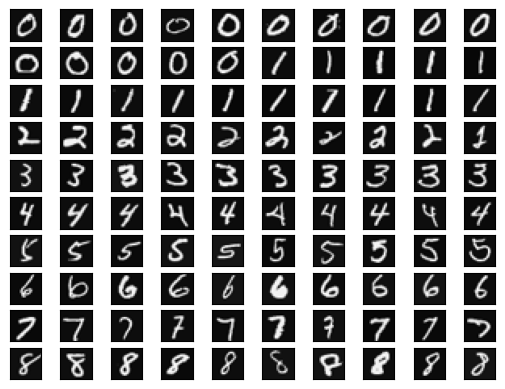

In [330]:
fig,ax = plt.subplots(nrows=10,ncols=10)
for i in range(10):
    for j in range(10):
        ax[i][j].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
        ax[i][j].imshow(X=raw_data["X"][i*450 + j*10].reshape(20,20).T,cmap='gray')
plt.show()

In [429]:
# Define a function 'sigmoid' to compute the sigmoid of 'z'.
def sigmoid(z):
    return 1/(1 + np.exp(-z))

# Define a function 'get_x' to get the feature matrix 'X' from 'raw_data'.
# 'raw_data' is a dictionary containing the data.
def get_x(raw_data):
    # 'X' is the feature matrix.
    X = raw_data["X"]
    # Insert a column of ones at the beginning of 'X' for the intercept term.
    X = np.insert(X,obj=0,values=1,axis=1)
    return X

# Define a function 'get_y' to get the target variable 'y' for a specific class.
# 'raw_data' is a dictionary containing the data.
def get_y(raw_data):
    # 'y' is the target variable.
    y = raw_data["y"]
    # Replace 10 with 0 in 'y'.
    y[y==10]=0
    # Create a 10x1 matrix of ones.
    ones = np.ones((10,1))
    # Multiply 'ones' by 'y' transposed to get a 10x5000 matrix 'Y'.
    Y = ones*y.T
    # Create a 10x5000 matrix 'i' where the value in each row is the row index.
    i,_ = np.indices((10, y.shape[0]))
    # Return a binary matrix where 1 indicates the class label and 0 indicates the other classes.
    return (Y==i).astype(int)

# 'X' is assigned the feature matrix obtained from 'raw_data'.
X = get_x(raw_data)
# 'Y' is assigned the target variable obtained from 'raw_data'.
Y = get_y(raw_data)
# 'y' is assigned the target variable obtained from 'raw_data' and flattened to a one-dimensional array.
y = raw_data["y"].flatten()
# Replace 10 with 0 in 'y'.
y[y==10]=0

X.shape:(5000, 401), Y.shape:(10, 5000)


array([0, 0, 0, ..., 9, 9, 9], dtype=uint8)

In [387]:
x_rlen = X.shape[1]
epsilon = 10**-3
theta = np.random.rand(25*x_rlen + 10*26)*2*epsilon - epsilon
def get_theta1(theta):
    return theta[:25*x_rlen].reshape(25,x_rlen)
def get_theta2(theta):
    return theta[25*x_rlen:].reshape(10,26)
print(f'theta1.shape:{get_theta1(theta).shape}, theta2.shape:{get_theta2(theta).shape}')

theta1.shape:(25, 401), theta2.shape:(10, 26)


In [388]:
# Define a function 'cost' to compute the regularized cost function for a neural network.
# 'theta' is the parameter vector.
# 'X' is the feature matrix (m x n).
# 'Y' is the target variable (m x k).
# 'lamda' is the regularization parameter.
def cost(theta,X,Y,lamda=1):
    # 'm' is the number of training examples.
    m = X.shape[0]
    # 'theta1' and 'theta2' are the parameter matrices for the first and second layer of the neural network, respectively.
    theta1 = get_theta1(theta) # shape: (s x (n+1))
    theta2 = get_theta2(theta) # shape: (k x (s+1))
    # Compute the first part of the cost function.
    part_one = -((Y * np.log(sigmoid(theta2@np.insert(sigmoid(theta1@X.T),obj=0,values=1,axis=0)))).sum(axis=0)).mean()
    # Compute the second part of the cost function.
    part_two = -(((1-Y) * np.log(1 - sigmoid(theta2@np.insert(sigmoid(theta1@X.T),obj=0,values=1,axis=0)))).sum(axis=0)).mean()
    # Compute the regularization term.
    part_regular = (lamda/(2*m))*(((theta1[:,1:])**2).sum() + ((theta2[:,1:])**2).sum())
    # Compute the regularized cost function.
    return part_one + part_two + part_regular

In [389]:
# Define a function 'gradient' to compute the gradient of the regularized cost function for a neural network.
# 'theta' is the parameter vector.
# 'X' is the feature matrix (m x n).
# 'Y' is the target variable (m x k).
# 'lamda' is the regularization parameter.
def gradient(theta,X,Y,lamda=1):
    # 'm' is the number of training examples.
    m = X.shape[0]
    # 'theta1' and 'theta2' are the parameter matrices for the first and second layer of the neural network, respectively.
    theta1 = get_theta1(theta) # shape: (s x (n+1))
    theta2 = get_theta2(theta) # shape: (k x (s+1))
    # Initialize matrices 'Theta1' and 'Theta2' to store the gradients for 'theta1' and 'theta2', respectively.
    Theta1 = np.zeros_like(theta1) # shape: (s x (n+1))
    Theta2 = np.zeros_like(theta2) # shape: (k x (s+1))
    # Compute the activations for the input layer, the hidden layer, and the output layer.
    a1 = np.delete(X.T,obj=0,axis=0) # shape: (n x m)
    a2 = sigmoid(theta1@np.insert(a1,obj=0,values=1,axis=0)) # shape: (s x m)
    a3 = sigmoid(theta2@np.insert(a2,obj=0,values=1,axis=0)) # shape: (k x m)
    # Compute the error terms for the output layer and the hidden layer.
    deta3 = a3 - Y # shape: (k x m)
    deta2 = np.delete(theta2.T@deta3,obj=0,axis=0)*a2*(1-a2) # shape: (s x m)
    # Loop over the training examples to compute the gradients for 'theta1' and 'theta2'.
    for i in range(X.shape[0]):
        Theta1+=deta2[:,i][:,np.newaxis]@np.insert(a1[:,i][np.newaxis,:],obj=0,values=1,axis=1)
        Theta2+=deta3[:,i][:,np.newaxis]@np.insert(a2[:,i][np.newaxis,:],obj=0,values=1,axis=1)
    # Store the first column of 'Theta1' and 'Theta2' before applying regularization.
    Theta1_0 = Theta1[:,[0]] # shape: (s x 1)
    Theta2_0 = Theta2[:,[0]] # shape: (k x 1)
    # Compute the regularized gradients for 'theta1' and 'theta2'.
    Theta1= (1/m)*Theta1 + (lamda/m)*theta1
    Theta2= (1/m)*Theta2 + (lamda/m)*theta2
    # Replace the first column of 'Theta1' and 'Theta2' with the stored values.
    Theta1[:,[0]] = Theta1_0
    Theta2[:,[0]] = Theta2_0
    #print(f"a1.shape:{a1.shape},a2.shape:{a2.shape},a3.shape:{a3.shape},deta3.shape:{deta3.shape},deta2.shape:{deta2.shape}")
    # Return the gradients as a one-dimensional array.
    return np.concatenate((Theta1.flatten(), Theta2.flatten()),axis=0)

In [413]:
gradient(theta,X,Y)

array([-1.18661861e+00,  1.07055666e-07,  1.44233060e-07, ...,  2.00558874e-01,  2.00249163e-01,
        2.00197338e-01])

In [414]:
res = optimize.minimize(cost,x0=theta,args=(X,Y),method='Newton-CG',jac=gradient)
res

     fun: 3.25343263453657
     jac: array([-4.38552639e-02,  1.07055577e-07,  1.44232940e-07, ...,  3.96273291e-03,  3.88882259e-03,
        3.97191916e-03])
 message: 'Optimization terminated successfully.'
    nfev: 48
    nhev: 0
     nit: 9
    njev: 57
  status: 0
 success: True
       x: array([ 5.93444800e-04,  5.35277863e-04,  7.21164670e-04, ..., -9.80121676e-05, -2.74538925e-04,
       -5.53175175e-04])

In [430]:
final_theta = res.x
def y_predict(final_theta,X):
    final_theta1 = get_theta1(final_theta) 
    final_theta2 = get_theta2(final_theta)
    result_mat = sigmoid(final_theta2@np.insert(sigmoid(final_theta1@X.T),obj=0,values=1,axis=0))
    result = np.argmax(result_mat,axis=0) 
    return result
y_pre = y_predict(final_theta,X)
y_true = y
cla_res = classification_report(y_true,y_pre,zero_division=0)

In [416]:
print(cla_res)

              precision    recall  f1-score   support

           0       0.03      0.03      0.03       500
           1       0.01      0.01      0.01       500
           2       0.27      0.56      0.37       500
           3       0.01      0.02      0.01       500
           4       0.04      0.01      0.02       500
           5       0.26      0.25      0.26       500
           6       0.10      0.08      0.09       500
           7       0.01      0.01      0.01       500
           8       0.08      0.10      0.09       500
           9       0.18      0.07      0.10       500

    accuracy                           0.11      5000
   macro avg       0.10      0.11      0.10      5000
weighted avg       0.10      0.11      0.10      5000

